This notebook uses the following files from other notebooks:
- the selected sequence and charge pickle from the notebook "analyse the isotope intensity adjustment by peptide"
- requires extracted frames converted run databases using the script "open-path/notebooks/extract-rt-apex-frames.py"

In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import sqlite3
import matplotlib.pyplot as plt

In [2]:
MAPPING_FILE_NAME = "/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/recalibrated-percolator-output/percolator-idx-mapping.csv"

# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result

#### select the sequence/charge of interest, and the runs to look at

In [3]:
selected_sequence = 'FSLPDQDGEQVNLTDFQGQR'
selected_sequence_charge = 2

In [4]:
selected_sequence_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/sequence-{}-charge-{}-df.pkl'.format(selected_sequence, selected_sequence_charge))

In [5]:
selected_sequence_df

,sequence,charge,file_idx,inferred,intensity,isotope_idx_not_in_saturation,isotope_intensities_l,mono_filtered_points_l,mono_raw_points_l,mono_rt_fitted_curve_l,...,batch,human,log_intensity,experiment_intensity_mean,experiment_intensity_std_dev,experiment_rt_mean,experiment_rt_std_dev,experiment_scan_mean,experiment_scan_std_dev,number_of_runs_for_sequence
15709,FSLPDQDGEQVNLTDFQGQR,2,11,0,2100,0,"[(2100.0, False, [(1147.5380363648126, 122.0, ...","[68.41258741258653, -5.251748251748879, 0.0932...","[(770.8688075544583, 10.0), (771.4040816517925...","[(780.7082616881908, 3913.141408450011), (781....",...,1to1,False,11.036174,11.634627,1.346118,778.715822,3.123697,128.196717,3.210244,19
22719,FSLPDQDGEQVNLTDFQGQR,2,16,0,2235,0,"[(2235.0, False, [(1147.5379845826385, 118.0, ...","[156.77622377622353, 101.32167832167806, 80.81...","[(766.8690752912113, 130.0), (768.489774714624...","[(779.3922419982478, 4653.803709328962), (779....",...,1to1,False,11.126059,11.634627,1.346118,778.715822,3.123697,128.196717,3.210244,19
8762,FSLPDQDGEQVNLTDFQGQR,2,6,0,3012,0,"[(3012.0, False, [(1147.538008796827, 121.0, 7...","[84.13986013986022, 171.30069930069936, 202.24...","[(767.1498238163149, 10.0), (767.7018163583948...","[(780.2691150558392, 5394.699625427026), (780....",...,1to1,False,11.556506,11.634627,1.346118,778.715822,3.123697,128.196717,3.210244,19
21334,FSLPDQDGEQVNLTDFQGQR,2,15,0,3388,0,"[(3388.0, False, [(1147.5380443078902, 115.0, ...","[114.15384615384593, 47.28671328671311, 34.132...","[(767.3929323104016, 102.0), (767.937475436546...","[(780.5053623923989, 5427.639675118966), (781....",...,1to1,False,11.726218,11.634627,1.346118,778.715822,3.123697,128.196717,3.210244,19
25607,FSLPDQDGEQVNLTDFQGQR,2,18,0,3193,0,"[(3193.0, False, [(1147.5380345259766, 120.0, ...","[202.5524475524476, 226.16783216783224, 236.99...","[(767.2265308167035, 152.0), (767.782021824795...","[(779.2500318281207, 6445.944223203707), (779....",...,1to1,False,11.640697,11.634627,1.346118,778.715822,3.123697,128.196717,3.210244,19
27030,FSLPDQDGEQVNLTDFQGQR,2,19,0,3475,0,"[(3475.0, False, [(1147.5380239344588, 115.0, ...","[9.573426573426579, 132.91608391608383, 195.55...","[(764.3852606084471, 113.0), (766.004020186707...","[(776.9378830503587, 4676.3926860832225), (777...",...,1to1,False,11.762797,11.634627,1.346118,778.715822,3.123697,128.196717,3.210244,19
1754,FSLPDQDGEQVNLTDFQGQR,2,1,0,2812,0,"[(2812.0, False, [(1147.5380288633874, 116.0, ...","[30.573426573426673, 56.47552447552446, 95.097...","[(765.6494663422941, 22.0), (766.1912062968873...","[(779.2743164185099, 5206.90406294253), (779.8...",...,1to1,False,11.457381,11.634627,1.346118,778.715822,3.123697,128.196717,3.210244,19
14326,FSLPDQDGEQVNLTDFQGQR,2,10,0,168,0,"[(168.0, False, [(1147.5380519079013, 113.0, 7...","[112.03496503496552, 29.15384615384552, 123.01...","[(769.3542157354125, 147.0), (769.893243132536...","[(784.58319546777, 192.94761389434862), (785.1...",...,1to1,False,7.392317,11.634627,1.346118,778.715822,3.123697,128.196717,3.210244,19
3095,FSLPDQDGEQVNLTDFQGQR,2,2,0,3281,0,"[(3281.0, False, [(1147.5379913334625, 108.0, ...","[186.32867132867062, 95.06293706293667, 84.158...","[(768.4122477693986, 168.0), (768.951927060063...","[(779.2586706832077, 5470.954353526979), (779....",...,1to1,False,11.679920,11.634627,1.346118,778.715822,3.123697,128.196717,3.210244,19
11590,FSLPDQDGEQVNLTDFQGQR,2,8,0,2789,0,"[(2789.0, False, [(1147.538064748466, 120.0, 7...","[49.57342657342671, 137.17482517482512, 175.77...","[(767.1671017810232, 30.0), (767.7086819146629...","[(778.6680020568532, 4630.332188623999), (779....",...,1to1,False,11.445532,11.634627,1.346118,778.715822,3.123697,128.196717,3.210244,19


In [6]:
selected_sequence_df.columns

Index(['sequence', 'charge', 'file_idx', 'inferred', 'intensity',
       'isotope_idx_not_in_saturation', 'isotope_intensities_l',
       'mono_filtered_points_l', 'mono_raw_points_l', 'mono_rt_fitted_curve_l',
       'mono_rt_isolated_peak_l', 'monoisotopic_mz', 'rt_apex', 'scan_apex',
       'classed_as', 'run_name', 'batch', 'human', 'log_intensity',
       'experiment_intensity_mean', 'experiment_intensity_std_dev',
       'experiment_rt_mean', 'experiment_rt_std_dev', 'experiment_scan_mean',
       'experiment_scan_std_dev', 'number_of_runs_for_sequence'],
      dtype='object')

In [8]:
# the runs of interest for comparison
run_name_A = '190719_Hela_Ecoli_1to1_07'
file_idx_A = file_idx_for_run(run_name_A)

run_name_B = '190719_Hela_Ecoli_1to1_08'
file_idx_B = file_idx_for_run(run_name_B)

#### compare the sequence in run A

In [9]:
# get the row for the selected run
sequence_in_file_A = selected_sequence_df[selected_sequence_df.file_idx == file_idx_A].iloc[0]

# convert the list of isotopes for thie sequence in this run into a DF
isotopes_A_df = pd.DataFrame(sequence_in_file_A.isotope_intensities_l, columns=['summed_intensity','saturated','isotope_points','isotope_apex_points','inferred_intensity','inferred'])

# extract the raw points of each isotope
frame_ids_A = set()
isotope_points_A_l = []
isotope_apex_points_A_l = []

for idx,isotope in isotopes_A_df.iterrows():
    points_l = isotope.isotope_points
    isotope_points_df = pd.DataFrame(points_l, columns=['mz','scan','frame_id','retention_time_secs','intensity'])
    isotope_points_A_l.append(isotope_points_df)
    
    apex_points_l = isotope.isotope_apex_points
    isotope_apex_points_df = pd.DataFrame(apex_points_l, columns=['mz','scan','frame_id','retention_time_secs','intensity'])
    isotope_apex_points_A_l.append(isotope_apex_points_df)
    frame_ids_A = frame_ids_A.union(isotope_apex_points_df.frame_id.astype(int).to_list())

# the frames to extract for the sequence's apex in RT
print("extract these frames from {}: {}".format(run_name_A, ' '.join([str(v) for v in frame_ids_A])))

extract these frames from 190719_Hela_Ecoli_1to1_07: 7305 7315 7310


#### compare the sequence in run B

In [11]:
# get the row for the selected run
sequence_in_file_B = selected_sequence_df[selected_sequence_df.file_idx == file_idx_B].iloc[0]

# convert the list of isotopes for thie sequence in this run into a DF
isotopes_B_df = pd.DataFrame(sequence_in_file_B.isotope_intensities_l, columns=['summed_intensity','saturated','isotope_points','isotope_apex_points','inferred_intensity','inferred'])

# extract the raw points of each isotope
frame_ids_B = set()
isotope_points_B_l = []
isotope_apex_points_B_l = []

for idx,isotope in isotopes_B_df.iterrows():
    points_l = isotope.isotope_points
    isotope_points_df = pd.DataFrame(points_l, columns=['mz','scan','frame_id','retention_time_secs','intensity'])
    isotope_points_B_l.append(isotope_points_df)
    
    apex_points_l = isotope.isotope_apex_points
    isotope_apex_points_df = pd.DataFrame(apex_points_l, columns=['mz','scan','frame_id','retention_time_secs','intensity'])
    isotope_apex_points_B_l.append(isotope_apex_points_df)
    frame_ids_B = frame_ids_B.union(isotope_apex_points_df.frame_id.astype(int).to_list())

# the frames to extract for the sequence's apex in RT
print("extract these frames from {}: {}".format(run_name_B, ' '.join([str(v) for v in frame_ids_B])))

extract these frames from 190719_Hela_Ecoli_1to1_08: 7361 7371 7366


#### run this command to extract the frames at the RT apex
- python ./open-path/notebooks/extract-rt-apex-frames.py -en dwm-test -rn 190719_Hela_Ecoli_1to1_09 -fid 9654 9659 9664

and download the output files

In [12]:
frames_subset_A_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/frames-subsets/{}-frames-subset-df.pkl'.format(run_name_A))
scan_lower = sequence_in_file_A.scan_apex - (10 * sequence_in_file_A.experiment_scan_std_dev)
scan_upper = sequence_in_file_A.scan_apex + (10 * sequence_in_file_A.experiment_scan_std_dev)
mz_lower = sequence_in_file_A.monoisotopic_mz - 1
mz_upper = sequence_in_file_A.monoisotopic_mz + 7
frames_subset_A_df = frames_subset_A_df[(frames_subset_A_df.scan >= scan_lower) & (frames_subset_A_df.scan <= scan_upper) & (frames_subset_A_df.mz >= mz_lower) & (frames_subset_A_df.mz <= mz_upper) & (frames_subset_A_df.frame_id.isin(list(frame_ids_A)))]

frames_subset_B_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/frames-subsets/{}-frames-subset-df.pkl'.format(run_name_B))
scan_lower = sequence_in_file_B.scan_apex - (10 * sequence_in_file_B.experiment_scan_std_dev)
scan_upper = sequence_in_file_B.scan_apex + (10 * sequence_in_file_B.experiment_scan_std_dev)
mz_lower = sequence_in_file_B.monoisotopic_mz - 1
mz_upper = sequence_in_file_B.monoisotopic_mz + 7
frames_subset_B_df = frames_subset_B_df[(frames_subset_B_df.scan >= scan_lower) & (frames_subset_B_df.scan <= scan_upper) & (frames_subset_B_df.mz >= mz_lower) & (frames_subset_B_df.mz <= mz_upper) & (frames_subset_B_df.frame_id.isin(list(frame_ids_B)))]


In [13]:
frame_subset_intensity_max = max(frames_subset_A_df.intensity.max(), frames_subset_B_df.intensity.max())


In [14]:
frame_subset_intensity_max

1700

#### plots for comparing the selected sequence in run A and run B

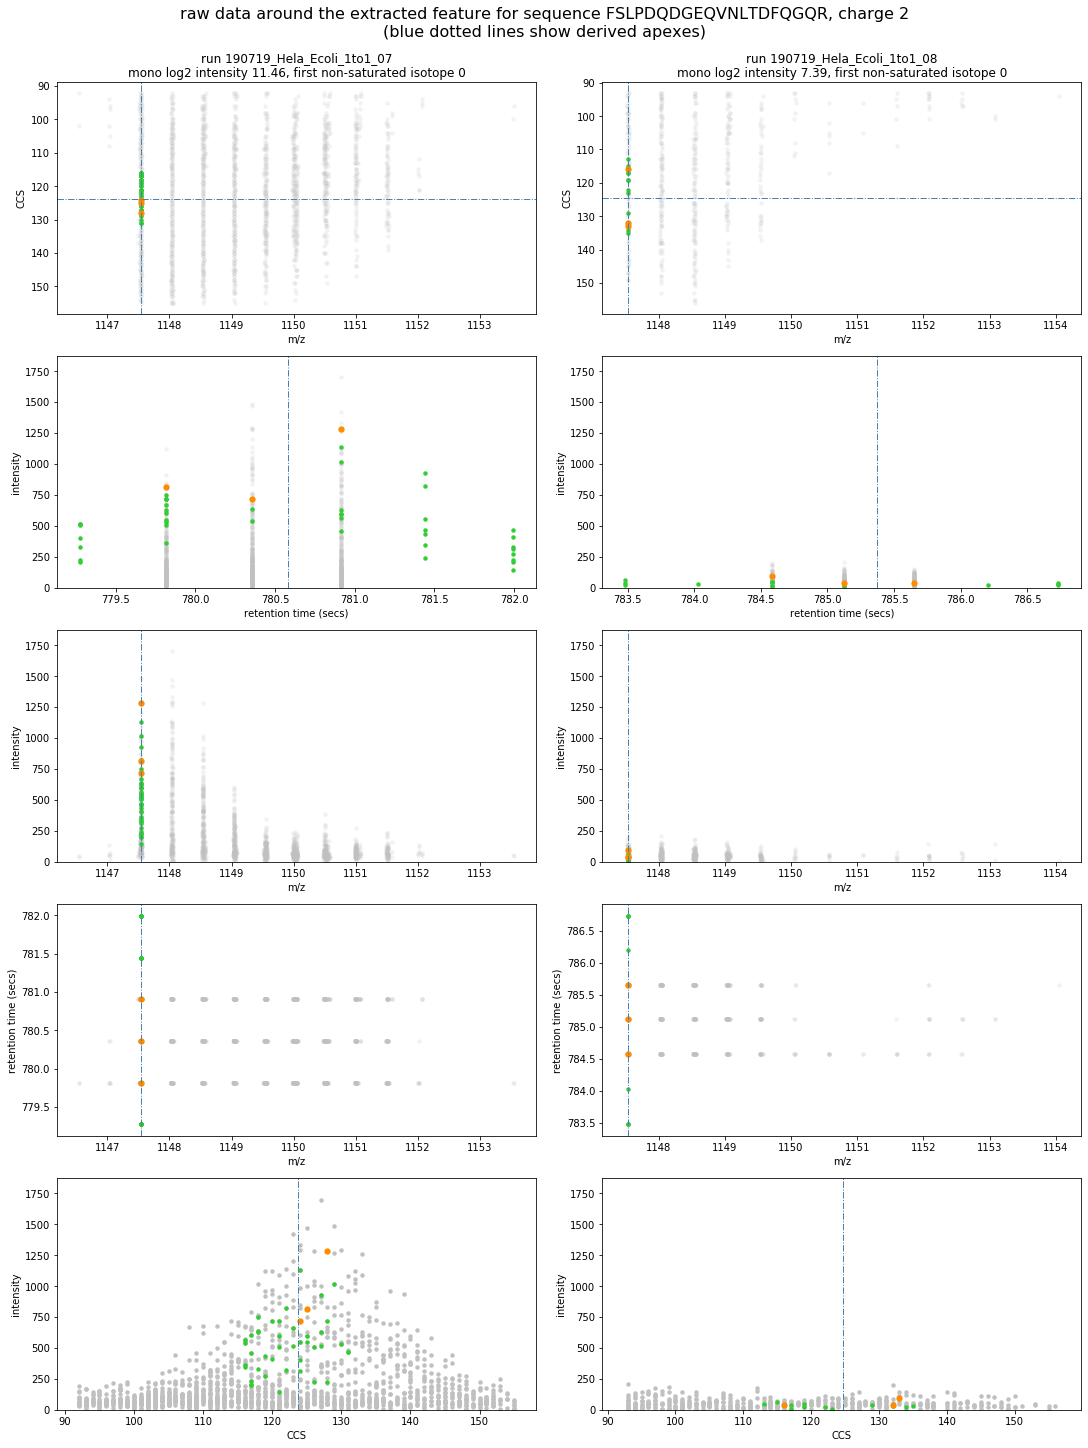

In [17]:
f, axarr = plt.subplots(nrows=5, ncols=2, constrained_layout=True)

f.set_figheight(20)
f.set_figwidth(15)
plt.margins(0.06)
f.suptitle('raw data around the extracted feature for sequence {}, charge {}\n(blue dotted lines show derived apexes)'.format(selected_sequence, selected_sequence_charge), fontsize=16)

########
# run A - mz vs scan
########
ax = axarr[0,0]  # row, column
ax.set_title('run {}\nmono log2 intensity {}, first non-saturated isotope {}'.format(sequence_in_file_A.run_name, round(sequence_in_file_A.log_intensity,2), sequence_in_file_A.isotope_idx_not_in_saturation))

# plot the background points in the feature region
ax.scatter(frames_subset_A_df.mz, frames_subset_A_df.scan, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# plot the isotope points
for df in isotope_points_A_l:
    ax.scatter(df.mz, df.scan, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
for df in isotope_apex_points_A_l:
    ax.scatter(df.mz, df.scan, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the monoisotopic apex
ax.axvline(sequence_in_file_A.monoisotopic_mz, color='steelblue', lw=1.0, ls='-.')
ax.axhline(sequence_in_file_A.scan_apex, color='steelblue', lw=1.0, ls='-.')

ax.set_xlabel('m/z')
ax.set_ylabel('CCS')
ax.invert_yaxis()

########
# run A - RT vs intensity
########
ax = axarr[1,0]

# plot the background points in the feature region
ax.scatter(frames_subset_A_df.retention_time_secs, frames_subset_A_df.intensity, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# plot the isotope points
df = isotope_points_A_l[0]
ax.scatter(df.retention_time_secs, df.intensity, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
df = isotope_apex_points_A_l[0]
ax.scatter(df.retention_time_secs, df.intensity, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the monoisotopic apex
ax.axvline(sequence_in_file_A.rt_apex, color='steelblue', lw=1.0, ls='-.')

ax.set_ylim((0,frame_subset_intensity_max*1.1))
ax.set_xlabel('retention time (secs)')
ax.set_ylabel('intensity')

########
# run A - mz vs intensity
########
ax = axarr[2,0]

# plot the background points in the feature region
ax.scatter(frames_subset_A_df.mz, frames_subset_A_df.intensity, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# plot the isotope points
for df in isotope_points_A_l:
    ax.scatter(df.mz, df.intensity, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
for df in isotope_apex_points_A_l:
    ax.scatter(df.mz, df.intensity, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the monoisotopic apex
ax.axvline(sequence_in_file_A.monoisotopic_mz, color='steelblue', lw=1.0, ls='-.')

ax.set_ylim((0,frame_subset_intensity_max*1.1))
ax.set_xlabel('m/z')
ax.set_ylabel('intensity')

########
# run A - mz vs RT
########
ax = axarr[3,0]

# plot the background points in the feature region
ax.scatter(frames_subset_A_df.mz, frames_subset_A_df.retention_time_secs, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# plot the isotope points
for df in isotope_points_A_l:
    ax.scatter(df.mz, df.retention_time_secs, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
for df in isotope_apex_points_A_l:
    ax.scatter(df.mz, df.retention_time_secs, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the monoisotopic apex
ax.axvline(sequence_in_file_A.monoisotopic_mz, color='steelblue', lw=1.0, ls='-.')

ax.set_xlabel('m/z')
ax.set_ylabel('retention time (secs)')

########
# run A - CCS vs intensity
########
ax = axarr[4,0]

# plot the background points in the feature region
ax.scatter(frames_subset_A_df.scan, frames_subset_A_df.intensity, marker='o', color='silver', lw=0, s=20, alpha=1.0)

# plot the isotope points
df = isotope_points_A_l[0]
ax.scatter(df.scan, df.intensity, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
df = isotope_apex_points_A_l[0]
ax.scatter(df.scan, df.intensity, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the scan apex
ax.axvline(sequence_in_file_A.scan_apex, color='steelblue', lw=1.0, ls='-.')

ax.set_ylim((0,frame_subset_intensity_max*1.1))
ax.set_xlabel('CCS')
ax.set_ylabel('intensity')





########
# run B - mz vs scan
########
ax = axarr[0,1]
ax.set_title('run {}\nmono log2 intensity {}, first non-saturated isotope {}'.format(sequence_in_file_B.run_name, round(sequence_in_file_B.log_intensity,2), sequence_in_file_B.isotope_idx_not_in_saturation))

# plot the background points in the feature region
ax.scatter(frames_subset_B_df.mz, frames_subset_B_df.scan, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# plot the isotope points
for df in isotope_points_B_l:
    ax.scatter(df.mz, df.scan, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
for df in isotope_apex_points_B_l:
    ax.scatter(df.mz, df.scan, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the monoisotopic apex
ax.axvline(sequence_in_file_B.monoisotopic_mz, color='steelblue', lw=1.0, ls='-.')
ax.axhline(sequence_in_file_B.scan_apex, color='steelblue', lw=1.0, ls='-.')

ax.set_xlabel('m/z')
ax.set_ylabel('CCS')
ax.invert_yaxis()

########
# run B - RT vs intensity
########
ax = axarr[1,1]

# plot the background points in the feature region
ax.scatter(frames_subset_B_df.retention_time_secs, frames_subset_B_df.intensity, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# plot the isotope points
df = isotope_points_B_l[0]
ax.scatter(df.retention_time_secs, df.intensity, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
df = isotope_apex_points_B_l[0]
ax.scatter(df.retention_time_secs, df.intensity, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the monoisotopic apex
ax.axvline(sequence_in_file_B.rt_apex, color='steelblue', lw=1.0, ls='-.')

ax.set_ylim((0,frame_subset_intensity_max*1.1))
ax.set_xlabel('retention time (secs)')
ax.set_ylabel('intensity')

########
# run B - mz vs intensity
########
ax = axarr[2,1]

# plot the background points in the feature region
ax.scatter(frames_subset_B_df.mz, frames_subset_B_df.intensity, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# plot the isotope points
for df in isotope_points_B_l:
    ax.scatter(df.mz, df.intensity, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
for df in isotope_apex_points_B_l:
    ax.scatter(df.mz, df.intensity, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the monoisotopic apex
ax.axvline(sequence_in_file_B.monoisotopic_mz, color='steelblue', lw=1.0, ls='-.')

ax.set_ylim((0,frame_subset_intensity_max*1.1))
ax.set_xlabel('m/z')
ax.set_ylabel('intensity')

########
# run B - mz vs RT
########
ax = axarr[3,1]

# plot the background points in the feature region
ax.scatter(frames_subset_B_df.mz, frames_subset_B_df.retention_time_secs, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# plot the isotope points
for df in isotope_points_B_l:
    ax.scatter(df.mz, df.retention_time_secs, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
for df in isotope_apex_points_B_l:
    ax.scatter(df.mz, df.retention_time_secs, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the monoisotopic apex
ax.axvline(sequence_in_file_B.monoisotopic_mz, color='steelblue', lw=1.0, ls='-.')

ax.set_xlabel('m/z')
ax.set_ylabel('retention time (secs)')

########
# run B - CCS vs intensity
########
ax = axarr[4,1]

# plot the background points in the feature region
ax.scatter(frames_subset_B_df.scan, frames_subset_B_df.intensity, marker='o', color='silver', lw=0, s=20, alpha=1.0)

# plot the isotope points
df = isotope_points_B_l[0]
ax.scatter(df.scan, df.intensity, marker='o', color='limegreen', lw=0, s=20, alpha=1.0)

# plot the isotope apex points
df = isotope_apex_points_B_l[0]
ax.scatter(df.scan, df.intensity, marker='o', color='darkorange', lw=0, s=40, alpha=1.0)

# draw the scan apex
ax.axvline(sequence_in_file_B.scan_apex, color='steelblue', lw=1.0, ls='-.')

ax.set_ylim((0,frame_subset_intensity_max*1.1))
ax.set_xlabel('CCS')
ax.set_ylabel('intensity')


plt.show()